In [266]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from collections import Counter
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from IPython.display import Image
import pydotplus
import graphviz
from sklearn.svm import SVC
import operator



pd.options.display.max_columns = 150
pd.options.display.max_rows = 150

%matplotlib inline


[Kaggle Dataset](https://www.kaggle.com/hugodarwood/epirecipes)

# Challenge

Transform this problem into a binary classifier and clean up the feature set. You can choose whether or not to include nutritional information, but try to cut your feature set down to the 30 most valuable features.

Good luck!

When you've finished that, also take a moment to think about bias. Is there anything in this dataset that makes you think it could be biased, perhaps extremely so?

There is. Several things in fact, but most glaringly is that we don't actually have a random sample. It could be, and probably is, that the people more likely to choose some kinds of recipes are more likely to give high reviews.

After all, people who eat chocolate _might_ just be happier people.

# Explore Dataset

In [267]:
df = pd.read_csv('data/epi_r.csv')

Majority of data is one hot encoded cateogorical features. The target variable for this challenge is recipe ratings. 

In [268]:
df.head()

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,30 days of groceries,advance prep required,alabama,alaska,alcoholic,almond,amaretto,anchovy,anise,anniversary,anthony bourdain,aperitif,appetizer,apple,apple juice,apricot,arizona,artichoke,arugula,asian pear,asparagus,aspen,atlanta,australia,avocado,back to school,backyard bbq,bacon,bake,banana,barley,basil,bass,bastille day,bean,beef,beef rib,beef shank,beef tenderloin,beer,beet,bell pepper,berry,beverly hills,birthday,biscuit,bitters,blackberry,blender,blue cheese,blueberry,boil,bok choy,bon appétit,bon app��tit,boston,bourbon,braise,bran,brandy,bread,breadcrumbs,breakfast,brie,brine,...,suzanne goin,sweet potato/yam,swiss cheese,switzerland,swordfish,taco,tailgating,tamarind,tangerine,tapioca,tarragon,tart,tea,tennessee,tequila,tested & improved,texas,thanksgiving,thyme,tilapia,tofu,tomatillo,tomato,tortillas,tree nut,tree nut free,triple sec,tropical fruit,trout,tuna,turnip,utah,valentine's day,vanilla,veal,vegan,vegetable,vegetarian,venison,vermont,vermouth,vinegar,virginia,vodka,waffle,walnut,wasabi,washington,"washington, d.c.",watercress,watermelon,wedding,weelicious,west virginia,westwood,wheat/gluten-free,whiskey,white wine,whole wheat,wild rice,windsor,wine,winter,wisconsin,wok,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
0,"Lentil, Apple, and Turkey Wrap",2.500,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Potato and Fennel Soup Hodge,3.750,165.0,6.0,7.0,165.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Mahi-Mahi in Tomato Olive Sauce,5.000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Spinach Noodle Casserole,3.125,54

There is clear discontinuity within the recipe ratings data. As we can see in the histogram below, the distribution is negatively skewed. Majority of the ratings are 4 or above. This will cause an extreme bias towards higher rating recipes within the modeling process.

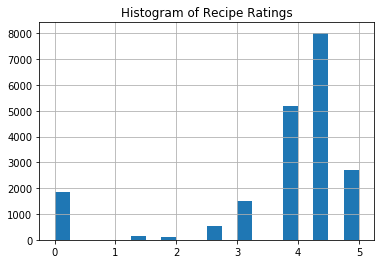

In [269]:
df.rating.hist(bins=20)
plt.title('Histogram of Recipe Ratings')
plt.show()

Currently the recipe ratings feature is continous. Since this a binary classification problem, we will create a new binary target variable by converting high value ratings to one and low value ratings to zero.

In [270]:
df['is_good'] = df.rating.apply(lambda x: 1 if x > 3 else 0)

In [271]:
df.is_good.value_counts()

1    17396
0     2656
Name: is_good, dtype: int64

even out target variable by sampling the same amount of high value with low value ratings

In [272]:
# even sampling between good and bad ratings
good_rating = good_rating.sample(2656, random_state=2)
print('Bad Ratings Sample: ', len(bad_rating))
print('Good Ratings Sample: ', len(good_rating))

Bad Ratings Sample:  2656
Good Ratings Sample:  2656


# Clean Variables

For this challenge we will only use binary features and not nutrition information.

In [273]:
bad_rating = df[df.is_good == 0]
good_rating = df[df.is_good == 1]

In [274]:
for df in [good_rating, bad_rating]:
    feature_count = {}
    for col in list(df.columns[6:-1]):
        value_count_dict = dict(df[col].value_counts())
        try:
            feature_count[col] = value_count_dict[1.0]
        except KeyError:
            feature_count[col] = 0

    #return top 30 most frequent binary features
    sorted_count = sorted(feature_count.items(), key=operator.itemgetter(1), reverse=True)
    feature_dict = dict(sorted_count)

    if df.is_good.mean() == 0:
        bad_feature_dict = feature_dict
    else:
        good_feature_dict = feature_dict
    

In [275]:
feature_ratio = {}
for key,val in good_feature_dict.items():
    if key in bad_feature_dict:
        if (val == 0) and bad_feature_dict[key] == 0:
            ratio = 0
        elif (val == 0) and (bad_feature_dict[key] != 0):
            ratio = np.log(good_feature_dict[key] / bad_feature_dict[key])
        elif (val != 0) and (bad_feature_dict[key] == 0):
            ratio = np.log(bad_feature_dict[key] / good_feature_dict[key])
        feature_ratio[key] = ratio


/Users/marshallmamiya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/Users/marshallmamiya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


In [276]:
for key,val in feature_ratio.items():
    if (val > 10) or (val < -10):
        print(key)

bon appétit
peanut free
soy free
tree nut free
vegetarian
gourmet
kosher
pescatarian
quick & easy
wheat/gluten-free
bake
summer
dessert
no sugar added
winter
side
dairy free
fall
dinner
sugar conscious
healthy
onion
kidney friendly
tomato
sauté
vegetable
milk/cream
fruit
egg
spring
herb
vegan
garlic
kid-friendly
salad
dairy
thanksgiving
cheese
roast
chicken
appetizer
lunch
no-cook
soup/stew
ginger
potato
grill/barbecue
chill
low cal
high fiber
lemon
christmas
pasta
food processor
pork
fish
sauce
backyard bbq
leafy green
nut
low fat
citrus
cocktail party
condiment/spread
mushroom
simmer
beef
chocolate
brunch
bell pepper
party
orange
paleo
cake
carrot
breakfast
parmesan
spice
mixer
apple
vinegar
mustard
pepper
poultry
marinate
drink
cilantro
blender
bacon
mint
bean
basil
almond
olive
shellfish
grill
rice
picnic
shrimp
broil
lime
white wine
parsley
potluck
yogurt
hot pepper
bread
alcoholic
turkey
berry
low cholesterol
cinnamon
boil
sour cream
fry
freeze/chill
sandwich
walnut
fruit juice
h

# Modeling

In [48]:
data = good_rating.append(bad_rating)
train_x, test_x, train_y, test_y = train_test_split(data[feature_list], data['is_good'], test_size=.3)

svc = SVC()
svc.fit(train_x, train_y)
svc.score(test_x, test_y)

TypeError: unhashable type: 'dict'

In [ ]:
plt.scatter(Y, svc.predict(X))